<a href="https://colab.research.google.com/github/JUBRIL-ADEBOGUN/Road-segment-classification-/blob/main/roadsegment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing neccessary packages.
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.models import Model

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import os, random
def tf_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # #For working on GPU from Tensorflow.
    #if tf.test.gpu_device_name() == '/device:GPU:0':
    #  os.environ['TF_DETERMINISTIC_OPS']=str(seed)
    # For working on CPU on Tensorflow.
    #else:
    #  os.environ['CUDA_VISSIBLE_DEVICE'] = ''
    #python_random.seed(seed)

    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
seed = 2022
tf_seed(seed)

In [ ]:
import pandas as pd

df_test = pd.read_csv('/content/drive/MyDrive/roadsegment/Test.csv', index_col='Image_ID')
df_train = pd.read_csv('/content/drive/MyDrive/roadsegment/Train.csv', index_col='Image_ID')
print(df_train.shape)
df_train.head()

(7000, 1)


,Target
Image_ID,
ID_0073qfb8,0
ID_00gy3vH2,1
ID_00uB3UFr,0
ID_012xZpNw,1
ID_014GgMRb,1


In [ ]:
print(df_test.shape)
df_test.head()

(3000, 0)


""
Image_ID
ID_01c6i2wd
ID_03sPqBLY
ID_06ZKUQFl
ID_06gzqIwK
ID_08kWat36


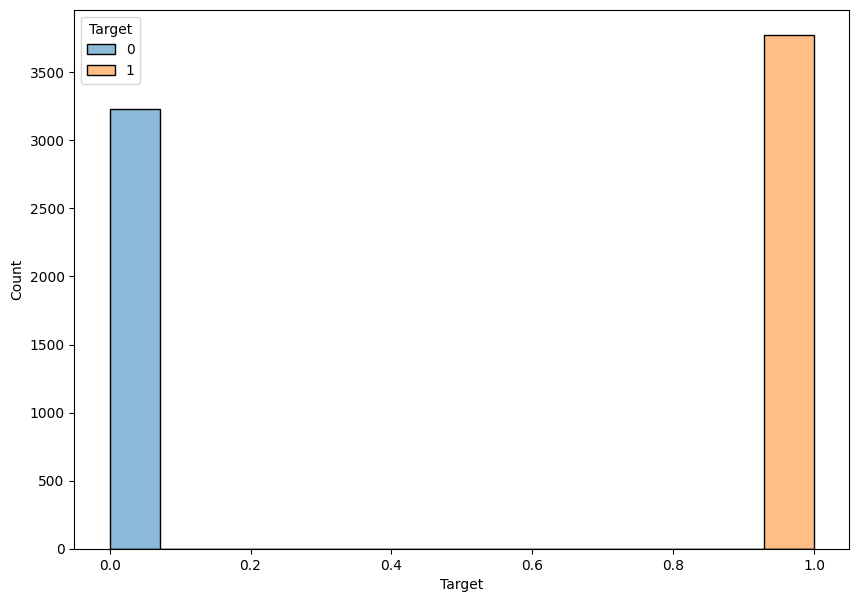

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.histplot(data=df_train, x='Target', hue='Target')
plt.show()

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(df_train.index, df_train['Target'], test_size=0.08, random_state=2022, stratify=df_train['Target'])
len(x_train), len(x_valid)

(6440, 560)

In [ ]:
path = '/content/drive/MyDrive/Images_con/'

train_list = [path+ x +'.jpg' for x in x_train]
valid_list = [path+ x +'.jpg' for x in x_valid]
test_list = [path+ x +'.jpg' for x in df_test.index]

train_list[:5]

['/content/drive/MyDrive/Images_con/ID_GoOOZRUg.jpg',
 '/content/drive/MyDrive/Images_con/ID_FNkxJwzK.jpg',
 '/content/drive/MyDrive/Images_con/ID_GP66XF4r.jpg',
 '/content/drive/MyDrive/Images_con/ID_NicKMf1z.jpg',
 '/content/drive/MyDrive/Images_con/ID_ntFkZLLJ.jpg']

In [ ]:
print(len(train_list), len(valid_list), len(test_list))

6440 560 3000


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_list, y_train))
val_data = tf.data.Dataset.from_tensor_slices((valid_list, y_valid))
test_data = tf.data.Dataset.from_tensor_slices((test_list))

In [ ]:
# create a parse function
def _parse_function(filename, labels):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    labels = tf.cast(labels, tf.int32)
    image = tf.image.resize(image, [224,224])
    image= image/255
    return image, labels

In [ ]:
train_set = train_data.map(_parse_function)
val_set = val_data.map(_parse_function)

train_set.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [ ]:
# create a parse function
def _parse_test_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, [224,224])
    image= image/255
    return image

test_set = test_data.map(_parse_test_function)
test_set.element_spec

TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
data_augmentation = keras.Sequential([
                                      layers.RandomFlip('horizontal', seed=seed),
                                      layers.RandomFlip('vertical', seed=seed),
                                      #layers.RandomCrop(height=0.2, width=0.2, seed=2022),
                                      #layers.RandomZoom(0.2, 0.2, seed=2022),
                                      #layers.RandomRotation(0.1, seed=seed, fill_mode='nearest'),
])

#train_set = train_set.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
#val_set = val_set.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
batch = 64
train_ds = train_set.cache().prefetch(buffer_size=AUTOTUNE).batch(batch)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE).batch(batch)

test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE).batch(batch)

In [ ]:
##plt.figure(figsize=(20,20))
#image= test_set.range(5) #next(iter(test_set))
#for imag, lbl in train_ds.take(1):
#  plt.figure(figsize=(30,30))
#  for i in range(15):
#    plt.subplot(3,5,i+1)
#    plt.xticks([])
#    plt.yticks([])
    #plt.grid(False)
#    plt.imshow(imag[i], cmap=plt.cm.binary)
#    plt.title(str(lbl[i].numpy()))
  # plt.imshow(imag)
  # #plt.imshow(tf.keras.utils.array_to_img(images))
  # plt.title('Trainig image')
  # plt.axis("off")
#plt.show()

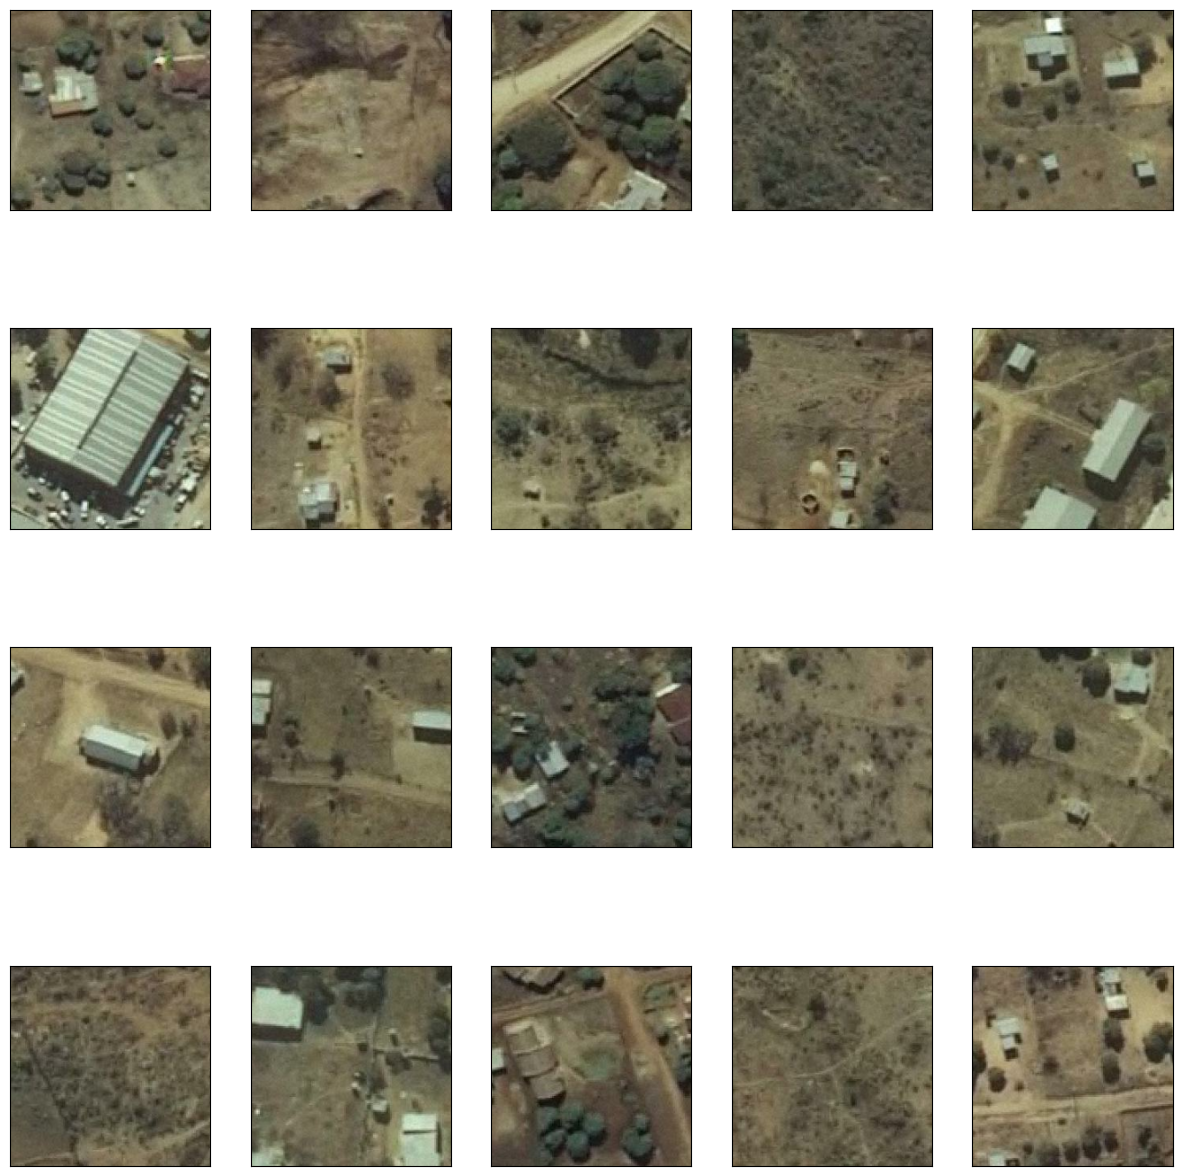

In [ ]:

for imag in test_ds.take(1):
  plt.figure(figsize=(15,20))
  for i in range(20):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(imag[i])
  plt.show()

In [ ]:
l2 = tf.keras.regularizers.L2(l2=0.001)

In [ ]:
dense_model = tf.keras.applications.densenet.DenseNet121(input_shape=(224, 224, 3),include_top=False,weights='imagenet')
#base_model2 = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(192, 192, 3))
eff_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3), include_preprocessing=False)
#model_4 = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,weights='imagenet',input_shape=(192, 192, 3))

82420632/82420632 [==============================] - 0s 0us/step


In [ ]:
dense_model.trainable = False
#base_model3.summary()

In [ ]:
input = keras.Input(shape=(224, 224, 3))
x = data_augmentation(input)
#scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
#x = scale_layer(x)
x = dense_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2)(x)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation='sigmoid', kernel_regularizer=l2)(x)

model = Model(inputs= input, outputs= output, name='efficientnet')
model.summary()

Model: "efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                      

In [ ]:
dense_model.trainable = True

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=[tf.keras.metrics.AUC(name='prc', curve='PR')])

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                                                 save_best_only=True, save_weights_only=True, mode='min')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
epochs = 10
earlystopping = tf.keras.callbacks.EarlyStopping(monitor= 'loss', mode='min', restore_best_weights=True, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=2, verbose=0, factor=0.9, min_lr=0.00001)


with tf.device('/device:GPU:0'):
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Epoch 1/10
101/101 [==============================] - 143s 858ms/step - loss: 1.2751 - prc: 0.9454 - val_loss: 1.1556 - val_prc: 0.9731
Epoch 2/10
101/101 [==============================] - 82s 809ms/step - loss: 1.0935 - prc: 0.9564 - val_loss: 0.9731 - val_prc: 0.9760
Epoch 3/10
101/101 [==============================] - 85s 840ms/step - loss: 0.9452 - prc: 0.9650 - val_loss: 0.8493 - val_prc: 0.9768
Epoch 4/10
101/101 [==============================] - 83s 825ms/step - loss: 0.8287 - prc: 0.9698 - val_loss: 0.7929 - val_prc: 0.9753
Epoch 5/10
101/101 [==============================] - 81s 803ms/step - loss: 0.7451 - prc: 0.9698 - val_loss: 0.6969 - val_prc: 0.9762
Epoch 6/10
101/101 [==============================] - 82s 809ms/step - loss: 0.6739 - prc: 0.9724 - val_loss: 0.6340 - val_prc: 0.9771
Epoch 7/10
101/101 [==============================] - 85s 846ms/step - loss: 0.6121 - prc: 0.9735 - val_loss: 0.6301 - val_prc: 0.9732
Epoch 8/10
101/101 [==============================] - 

In [ ]:
os.listdir(checkpoint_dir)

['cp.ckpt.index', 'checkpoint', 'cp.ckpt.data-00000-of-00001']

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

In [ ]:
model.evaluate(val_ds)

9/9 [==============================] - 2s 193ms/step - loss: 1.0445 - prc: 0.9757


[1.0445133447647095, 0.9756765365600586]

In [ ]:
with tf.device('/device:GPU:0'):
    pred = model.predict(test_ds)
#predt = modelt.predict(test_ds)

47/47 [==============================] - 628s 14s/step


In [ ]:
df_test['Target'] = pred
#df_test['predictiont'] = predt
#df_test['sub'] = (df_test['predictionr']+df_test['predictiont'])/2
#df_test.drop('prediction1', axis=1, inplace=True)
df_test.head(20)

,Target
Image_ID,
ID_01c6i2wd,0.079156
ID_03sPqBLY,0.133873
ID_06ZKUQFl,0.999600
ID_06gzqIwK,0.010051
ID_08kWat36,0.354590
ID_09Ek7abU,0.529755
ID_0AniuG5s,0.957300
ID_0BsPuUz7,0.275708
ID_0DSBT3ti,0.091140


In [ ]:
df_test[['Target']].to_csv('roadseg_loss.csv')